In [57]:
text = """Jupyter Notebook
humbleCDCL-100-samples
Last Checkpoint: godzinę temu
(autosaved)
Current Kernel Logo
Logout
Python 3 Trusted
File
Edit
View
Insert
Cell
Kernel
Widgets
Help
Run
In [1]:

import tensorflow as tf
from tensorflow.contrib import predictor
​
export_dir = "gs://neural-guidance-tensorflow/export/0315_series5a_sr50_l40_aTrue_tng-tpu-02/1552773431/"
predict_fn = predictor.from_saved_model(export_dir)
INFO:tensorflow:Restoring parameters from gs://neural-guidance-tensorflow/export/0315_series5a_sr50_l40_aTrue_tng-tpu-02/1552773431/variables/variables
In [2]:

from matplotlib import pyplot as plt
import numpy as np
import random
In [27]:

import tqdm
In [4]:

from time import time
In [5]:

import sys 
sys.path.insert(0,'../..')
In [6]:

from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL, JeroslowWangDPLL
import cdcl
CDCL = cdcl.CDCL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR, get_sat_SR, get_random_sat_kcnf
from tqdm import tqdm
from collections import Counter
In [7]:

LIMIT_RUNS = 1000
In [8]:

CDCL().run(CNF([[-1, -2], [+1, -2], [+1, +2]]))
Out[8]:
[1, -2]
In [9]:

JeroslowWangDPLL().run(CNF([[-1, -2], [+1, -2], [+1, +2]]))
Out[9]:
[1, -2]
In [10]:

cnf = get_pos_SR(15, 15, 2000)
print("Generated")
# print(cnf)
start = time()
CDCL().run(cnf)
end = time()
print(end-start)
start = time()
DPLL().run(cnf)
end = time()
print(end-start)
Generated
0.0866234302520752
0.10194969177246094
In [11]:

import math
from collections import defaultdict
​
def jw(clauses):
    score = defaultdict(int)
​
    for clause in clauses:
        for l in clause:
            score[l] += 2. ** (-len(clause))
​
    return max(score, key=score.get)
In [12]:

jw([[-1, -2], [+1, -2]])
Out[12]:
-2
In [13]:

np.set_printoptions(precision=3, suppress=True)
In [14]:

import tensorflow as tf
import os
​
BATCH_SIZE = 1
In [15]:

VERBOSE = False
TIMEOUT = 10000
cdcl.VERBOSE = VERBOSE
cdcl.TIMEOUT = TIMEOUT
​
class GraphBasedCDCL(CDCL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        output = predict_fn({"input": inputs})
        policy_probs = output['policy_probabilities']
        sat_prob = output['sat_probabilities'][0]
        
        #print("CNF:", input_cnf, end=' ', file=logfile)
        #print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        #print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                #print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        #print("best_svar:", best_svar, file=logfile)
        if VERBOSE:
            print("Chosen neural", best_svar)
            print("Pred SAT prob", sat_prob)
        return best_svar
​
class HumbleGraphBasedCDCL(CDCL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        output = predict_fn({"input": inputs})
        policy_probs = output['policy_probabilities']
        sat_prob = output['sat_probabilities'][0]
        
        #print("CNF:", input_cnf, end=' ', file=logfile)
        #print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        #print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                #print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        #print("best_svar:", best_svar, file=logfile)
        if VERBOSE:
            print("Chosen neural", best_svar)
            print("Pred SAT prob", sat_prob)
        if sat_prob < 0.3:
            # Overwriting with JW
            best_svar = jw(input_cnf.clauses)
            if VERBOSE:
                print("Choosing JW", best_svar)
        #if sat_prob < 0.02:
        #    print("Aborting, prob too small")
        #    raise ValueError("Prob too small")
        return best_svar
​
class JeroslawCDCL(CDCL):
    def suggest(self, cnf: CNF):
        res = jw(cnf.clauses)
        if VERBOSE:
            print("Chosen JW", res)
        return res
In [16]:

HumbleGraphBasedCDCL().run(CNF([[-1, -2], [+1, +3], [+2, -3], [+3, -2], [+1, -2], [2, 3]]))
In [17]:

def compute_steps(sats, cdcl_cls):
    steps = []
    solved = 0
    for sat in tqdm.tqdm(sats):
        cdcl = cdcl_cls()
        res = cdcl.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(cdcl.number_of_runs)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps
In [18]:

def compute_and_print_steps(sats, dpll_cls):
    try:
        print("")
        print("Results of {}".format(dpll_cls.__name__))
        steps = compute_steps(sats, dpll_cls)
        print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}".format(
            len(steps), np.mean(steps), np.std(steps)))
        print("Table: {}".format(steps))
    except Exception as e:
        print(e)
        print("Timeout!", TIMEOUT, "steps")
​
In [19]:

def print_all(s, n, m, light=False, seed=1, to_test=[HumbleGraphBasedCDCL, JeroslawCDCL]):
    print("Starting...")
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(seed)
    np.random.seed(seed)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    # compute_and_print_steps(sats, SimplifiedGraphBasedDPLL)
    
    
    # compute_and_print_steps(sats, SimplifiedMostCommonDPLL)
    # compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    
    #compute_and_print_steps(sats, GraphBasedCDCL)
    for method in to_test:
        compute_and_print_steps(sats, method)
    #logfile.flush()
In [20]:

# 30
We have generated 100 formulas

Results of HumbleGraphBasedCDCL
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.02it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 17.77; stdev step: 18.44
Table: [7, 28, 23, 14, 14, 48, 15, 14, 5, 11, 34, 11, 10, 13, 17, 15, 109, 11, 8, 8, 58, 14, 21, 13, 10, 14, 11, 11, 106, 18, 13, 7, 8, 7, 13, 48, 7, 12, 36, 14, 13, 9, 53, 10, 10,16, 11, 9, 10, 11, 32, 11, 8, 64, 65, 27, 8, 9, 10, 12, 11, 9, 14, 10, 7, 19, 10, 10, 6, 18, 6, 62, 15, 12, 8, 9, 6, 13, 35, 15, 10, 13, 13, 16, 10, 8, 9, 9, 9, 8, 9, 11, 6, 8, 45,11, 8, 5, 9, 11]

Results of JeroslawCDCL
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  6.90it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 19.72; stdev step: 13.05
Table: [11, 34, 11, 16, 11, 11, 36, 12, 8, 39, 11, 21, 12, 34, 18, 12, 7, 11, 8, 29, 23, 13, 44, 17, 15, 16, 15, 12, 7, 20, 83, 10, 5, 20, 10, 40, 16, 34, 27, 9, 19, 20, 26, 33, 19, 23, 22, 22, 36, 20, 18, 11, 12, 38, 32, 44, 10, 13, 7, 24, 31, 41, 32, 36, 8, 34, 10,10, 11, 14, 8, 39, 17, 12, 25, 13, 7, 26, 9, 12, 8, 37, 37, 11, 7, 10, 5, 11, 9, 38, 20, 8, 11, 13, 57, 9, 24, 9, 7, 9]

print_all(100, 1000, 40)
Starting...
  0%|          | 0/100 [00:00<?, ?it/s]
We have generated 100 formulas

Results of HumbleGraphBasedCDCL
100%|██████████| 100/100 [06:14<00:00,  4.28s/it]
  0%|          | 0/100 [00:00<?, ?it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 34.47; stdev step: 43.16
Table: [11, 17, 11, 20, 17, 41, 14, 15, 18, 25, 158, 56, 13, 10, 11, 13, 6, 19, 157, 16, 35, 158, 39, 17, 14, 14, 10, 17, 19, 13, 17, 14, 83, 13, 13, 17, 13, 18, 24, 18, 21, 15, 16, 28, 29, 12, 8, 14, 12, 11, 215, 17, 15, 20, 9, 23, 19, 217, 22, 14, 8, 9, 20, 144, 17, 16, 15, 40, 14, 29, 23, 24, 18, 12, 18, 70, 71, 19, 45, 13, 52, 12, 13, 16, 96, 18, 14, 13, 14, 131, 39, 106, 104, 92, 18, 15, 14, 12, 12, 80]

Results of JeroslawCDCL
100%|██████████| 100/100 [00:58<00:00,  1.15it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 41.19; stdev step: 29.28
Table: [51, 79, 58, 11, 11, 36, 50, 45, 25, 42, 18, 52, 54, 9, 16, 15, 20, 25, 70, 51, 21, 41, 35, 27, 48, 17, 30, 12, 45, 11, 33, 26, 57, 27, 18, 34, 14, 68, 70, 14, 21, 45, 17, 20, 28, 60, 42, 12, 29, 9, 13, 15, 9, 20, 43, 120, 46, 103, 14, 10, 12, 35, 109, 106, 13, 28, 21, 56, 45, 47, 74, 85, 27, 30, 22, 103, 92, 17, 45, 27, 63, 15, 26, 13, 81, 28, 14, 63, 18, 157, 45, 67, 73, 102, 16, 42, 69, 85, 27, 59]

In [29]:

print_all(100, 1000, 50)
Starting...
  0%|          | 0/100 [00:00<?, ?it/s]
We have generated 100 formulas

Results of HumbleGraphBasedCDCL
100%|██████████| 100/100 [12:28<00:00, 10.91s/it]
  0%|          | 0/100 [00:00<?, ?it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 56.71; stdev step: 67.96
Table: [14, 10, 25, 31, 17, 16, 24, 20, 21, 13, 24, 21, 254, 90, 18, 103, 160, 22, 203, 148, 44, 24, 15, 21, 16, 25, 32, 29, 24, 24, 15, 14, 14, 13, 23, 168, 29, 65, 16, 46, 24, 63, 18, 54, 22, 18, 17, 56, 157, 17, 16, 23, 14, 72, 12, 204, 33, 264, 22, 22, 19, 41, 12, 15, 16, 12, 280, 16, 206, 22, 109, 22, 20, 16, 24, 16, 135, 292, 92, 12, 152, 161, 12, 28, 85, 27, 16, 9, 17, 16, 23, 19, 210, 33, 14, 115, 139, 81, 17, 101]

Results of JeroslawCDCL
100%|██████████| 100/100 [02:23<00:00,  1.50s/it]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 71.46; stdev step: 58.22
Table: [20, 12, 110, 46, 59, 123, 58, 14, 115, 16, 25, 77, 175, 116, 288, 112, 85, 172, 19, 58, 40, 25, 23, 13, 25, 32, 102, 41, 229, 36, 40, 22, 11, 40, 20, 170, 108, 38, 39, 21, 87, 84, 79, 66, 28, 216, 62, 133, 260, 71, 13, 30, 8, 79, 19, 48, 70, 24, 19, 13, 111, 20, 26, 45, 66, 11, 34, 15, 111, 26, 19, 36, 17, 74, 132, 50, 102, 159, 144, 12, 137, 125, 41, 113, 123, 33, 75, 99, 102, 17, 61, 83, 155, 164, 38, 94, 143, 16, 54, 79]

In [30]:

print_all(100, 2000, 60)
Starting...
  0%|          | 0/100 [00:00<?, ?it/s]
We have generated 100 formulas

Results of HumbleGraphBasedCDCL
100%|██████████| 100/100 [40:59<00:00, 24.28s/it] 
  0%|          | 0/100 [00:00<?, ?it/s]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 142.73; stdev step: 212.65
Table: [20, 19, 18, 163, 18, 155, 36, 661, 23, 107, 15, 256, 847, 543, 463, 26, 23, 443, 33, 27, 19, 45, 230, 29, 31, 28, 303, 19, 130, 134, 17, 398, 293, 480, 23, 26, 21, 32, 34, 25, 37, 351, 61, 30, 25, 26, 17, 479, 24, 180, 170, 29, 27, 25, 16, 76, 16, 23, 25, 22, 22, 103, 28, 279, 22, 30, 1174, 132, 69, 20, 55, 254, 28, 313, 28, 25, 826, 39, 12, 38, 30, 16, 23, 290, 101, 24, 543, 19, 143, 24, 30, 110, 62, 119, 302, 745, 23, 145, 85, 70]

Results of JeroslawCDCL
100%|██████████| 100/100 [06:53<00:00,  2.70s/it]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 139.65; stdev step: 121.14
Table: [137, 174, 27, 117, 282, 332, 98, 142, 241, 378, 19, 417, 81, 246, 313, 17, 114, 105, 50, 35, 143, 43, 290, 106, 18, 41, 142, 86, 104, 42, 231, 295, 80, 478, 138, 59, 313, 24, 116, 26, 217, 322, 16, 106, 98, 64, 26, 391, 206, 175, 209, 26, 31, 172, 61, 111, 24, 170, 17, 279, 99, 225, 24, 64, 23, 561, 409, 45, 40, 195, 16, 409, 25, 190, 32, 15, 73, 17, 93, 117, 152, 238, 76, 359, 173, 27, 188, 26, 154, 37, 156, 39, 111, 134, 34, 16, 262, 183, 72, 35]

In [*]:

print_all(100, 2000, 70)
Starting...
  0%|          | 0/100 [00:00<?, ?it/s]
We have generated 100 formulas

Results of HumbleGraphBasedCDCL
  8%|▊         | 8/100 [04:07<25:15, 16.48s/it]  
In [*]:

print_all(100, 2000, 90)
In [*]:

print_all(110, 2000, 110)
In [ ]:

​

# 70
Starting...
We have generated 100 formulas

Results of HumbleGraphBasedCDCL
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:03:11<00:00, 91.23s/it]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 300.72; stdev step: 457.60
Table: [353, 620, 18, 25, 60, 22, 36, 24, 576, 814, 23, 423, 21, 35, 821, 24, 193, 173, 1859, 965, 23, 73, 56, 162, 450, 274, 176, 22, 789, 165, 2575, 26, 25, 18, 17, 26, 31, 119, 98, 42, 1611, 886, 1431, 252, 27, 38, 18, 41, 29, 55, 26, 127, 36, 945, 374, 641, 464, 29, 801, 209, 347, 144, 28, 19, 20, 28, 35, 657, 31, 32, 35, 185, 18, 29, 64, 920, 23, 107, 17, 20, 33, 184, 34, 31, 25, 31, 1263, 1104, 745, 410, 621, 107, 22, 585, 290, 27, 126, 32, 1323, 28]

Results of JeroslawCDCL
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:45<00:00, 14.11s/it]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 277.24; stdev step: 262.63
Table: [377, 244, 63, 159, 35, 140, 41, 33, 428, 983, 64, 255, 577, 611, 433, 37, 373, 78, 373, 87, 177, 84, 147, 181, 59, 83, 76, 20, 62, 170, 1450, 45, 227, 401, 402, 211, 270, 1030, 171, 304, 756, 945, 828, 92, 232, 379, 16, 236, 326, 393, 20, 447, 181, 591, 55, 751, 271, 159, 404, 303, 37, 441, 253, 83, 14, 113, 134, 524, 84, 42, 836, 46, 55, 470, 125, 205, 146, 140, 27, 101, 68, 373, 177, 239,180, 285, 429, 236, 319, 69, 550, 402, 179, 89, 367, 116, 369, 168, 837, 50]


# 80
Starting...
We have generated 100 formulas

Results of HumbleGraphBasedCDCL
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [3:49:31<00:00, 97.34s/it]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 433.58; stdev step: 600.04
Table: [302, 24, 546, 31, 26, 33, 36, 43, 1248, 1420, 2595, 32, 979, 22, 573, 354, 30, 1755, 302, 1963, 341, 26, 39, 23, 52, 2020, 962, 729, 385, 27, 36, 331, 848, 36, 26, 1124, 391, 32, 154, 36, 29, 691, 135, 92, 28, 1284, 637, 1027, 25, 263, 42, 36, 30, 2100, 119, 805, 76, 586, 1023, 15, 714, 227, 25, 842, 28, 25, 536, 260, 171, 1125, 20, 295, 32, 682, 805,39, 20, 3005, 400, 39, 229, 24, 773, 1055, 23, 21, 27, 90, 22, 199, 708, 43, 29, 37, 25, 38, 420, 27, 1267, 36]

Results of JeroslawCDCL
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [45:12<00:00, 44.49s/it]
Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 447.20; stdev step: 380.07
Table: [389, 632, 410, 242, 135, 245, 449, 528, 284, 1422, 130, 443, 788, 36, 154, 99, 607, 548, 910, 500, 274, 329, 35, 36, 309, 949, 1175, 452, 574, 436, 380, 506, 836, 338, 216,993, 1222, 89, 75, 24, 75, 29, 259, 586, 71, 298, 1281, 325, 404, 224, 1346, 208, 169,1198, 996, 117, 91, 273, 1069, 766, 636, 57, 777, 610, 21, 437, 309, 163, 226, 595, 886, 541, 118, 503, 1328, 1438, 40, 574, 530, 39,45, 27, 853, 586, 57, 621, 108, 144, 59, 114, 64, 329, 180, 203, 259, 377, 668, 117, 1426, 671]


"""

In [58]:
steps = [eval(l) for l in [line[len('Table: '):] for line in text.strip().split('\n') if 'Table: ' in line][1:]]

In [59]:
# steps.insert(-1, None)


In [60]:
humble = steps[::2]
jeroslaw = steps[1::2]

In [61]:
def compare(series1, series2):
    win1, match, win2 = [], [], []
    for (a1, a2) in zip(series1, series2):
        w1 = sum(1 for (x1, x2) in zip(a1, a2) if x1 < x2)
        m = sum(1 for (x1, x2) in zip(a1, a2) if x1 == x2)
        w2 = sum(1 for (x1, x2) in zip(a1, a2) if x1 > x2)
        print('[1]<[2]', w1)
        print('[1]=[2]', m)
        print('[1]>[2]', w2)
        print('--')
        win1.append(w1)
        match.append(m)
        win2.append(w2)
    return win1, match, win2

In [65]:
w1, m, w2 = compare(humble, jeroslaw)

[1]<[2] 61
[1]=[2] 7
[1]>[2] 32
--
[1]<[2] 63
[1]=[2] 4
[1]>[2] 33
--
[1]<[2] 67
[1]=[2] 1
[1]>[2] 32
--
[1]<[2] 61
[1]=[2] 0
[1]>[2] 39
--
[1]<[2] 65
[1]=[2] 0
[1]>[2] 35
--
[1]<[2] 63
[1]=[2] 1
[1]>[2] 36
--


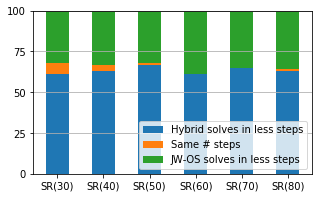

In [73]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))

N = 6
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, w1, width)
p2 = plt.bar(ind, m, width, bottom=w1)
p3 = plt.bar(ind, w2, width,
             bottom=np.array(w1) + np.array(m))

plt.xticks(ind, ('SR(30)', 'SR(40)', 'SR(50)', 'SR(60)', 'SR(70)', 'SR(80)'))
plt.ylim(top=100)
plt.yticks([0, 25, 50, 75, 100])
plt.grid(axis='y')
plt.legend((p1[0], p2[0], p3[0]), ('Hybrid solves in less steps', 'Same # steps', 'JW-OS solves in less steps'),
            loc='lower right')
plt.savefig('cdcl-win.pdf')
